In [1]:
import os
import random
import itertools
import re

# 基本的なライブラリ
import numpy as np
import pandas as pd
import scipy as sp
from scipy import stats

# 描画ライブラリ
import matplotlib.pyplot as plt
import seaborn as sns
from seaborn_analyzer import CustomPairPlot
import graphviz
import pydotplus
from IPython.display import Image
from IPython.display import HTML
from six import StringIO
from ipywidgets import interact, FloatSlider
from dtreeviz.trees import *

# データセット分割
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import ShuffleSplit, StratifiedShuffleSplit

# 補完
from sklearn.experimental import (
    enable_iterative_imputer,
)  # IterativeImputerをimportするために必要
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer

# エンコード
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder

# サンプリング
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# 特徴量選択
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import (
    GenericUnivariateSelect,
    f_classif,
    mutual_info_classif,
    chi2,
)
from boruta import BorutaPy
from libraries.mrmr import mrmr

# 学習中
import optuna
from tqdm import tqdm
from sklearn.model_selection import learning_curve, cross_validate, cross_val_score

# 評価指標
from sklearn.metrics import roc_auc_score
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


import shap

import warnings


# config python file
import config

SEED = config.SEED

from functions import *

fix_seed(SEED)


# 最大表示列数の指定（ここでは50列を指定）N
pd.set_option("display.max_columns", 50)
pd.set_option("display.max_rows", 50)

%matplotlib inline

# データ読み込み

In [2]:
X_dict = pickle_load(
    config.INTERIM_PICKLE_PREPROCESSED_PROGNOSIS_CROSS_DIR + "/X_dict.pickle"
)
y_dict = pickle_load(
    config.INTERIM_PICKLE_PREPROCESSED_PROGNOSIS_CROSS_DIR + "/y_dict.pickle"
)

In [3]:
X_train = X_dict["genes"]["mrmr"]["train"]["X15"]
y_train = y_dict["genes"]["mrmr"]["train"]["y15"]
X_test = X_dict["genes"]["mrmr"]["test"]["X15"]
y_test = y_dict["genes"]["mrmr"]["test"]["y15"]

assert X_train.shape[0] == y_train.shape[0], "train size is incorrect"
assert X_test.shape[0] == y_test.shape[0], "test size is incorrect"
assert X_train.shape[1] == X_test.shape[1], "feature size is incorrect"

# accuracyの表示
print("----------" * 10)
print("使用特徴量：", X_train.columns)
print("学習サンプルサイズ：", X_train.shape)
display("ラベル比率：", y_train.value_counts())

----------------------------------------------------------------------------------------------------
使用特徴量： Index(['RACGAP1', 'SMAD6', 'ELL2', 'RND1', 'C12orf76', 'RNU11', 'ENC1',
       'LOC389033', 'WARS2', 'INTS10', 'LSR', 'STAT5B', 'WDR67', 'LRRC50',
       'CPT1A', 'FAM5C', 'TFPT', 'VPS37A', 'FGD3', 'ELF3', 'ZIC2', 'C11orf54',
       'BX105743', 'HNRNPL', 'AK3', 'PREX1', 'DIRAS3', 'ATXN7L3B', 'IGFALS',
       'C9orf95', 'S100P', 'GSTM2', 'KCTD9', 'MST1', 'HIST1H4C'],
      dtype='object')
学習サンプルサイズ： (792, 35)


'ラベル比率：'

1    425
0    367
Name: OS_15years, dtype: int64

# モデル作成

## Random Forest

In [4]:
params = {
    "n_estimators": 500,
    "criterion": "entropy",
    "max_depth": 5,
    "max_leaf_nodes": 20,
    "max_features": "log2",
    "class_weight": "balanced",
    "random_state": SEED,
}
rf = RandomForestClassifier(**params)

rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

show_scores(y_test, y_pred)

accuracy:  0.6515151515151515
precision:  0.6762589928057554
recall:  0.6666666666666666
f1 score:  0.6714285714285714


### dtree

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


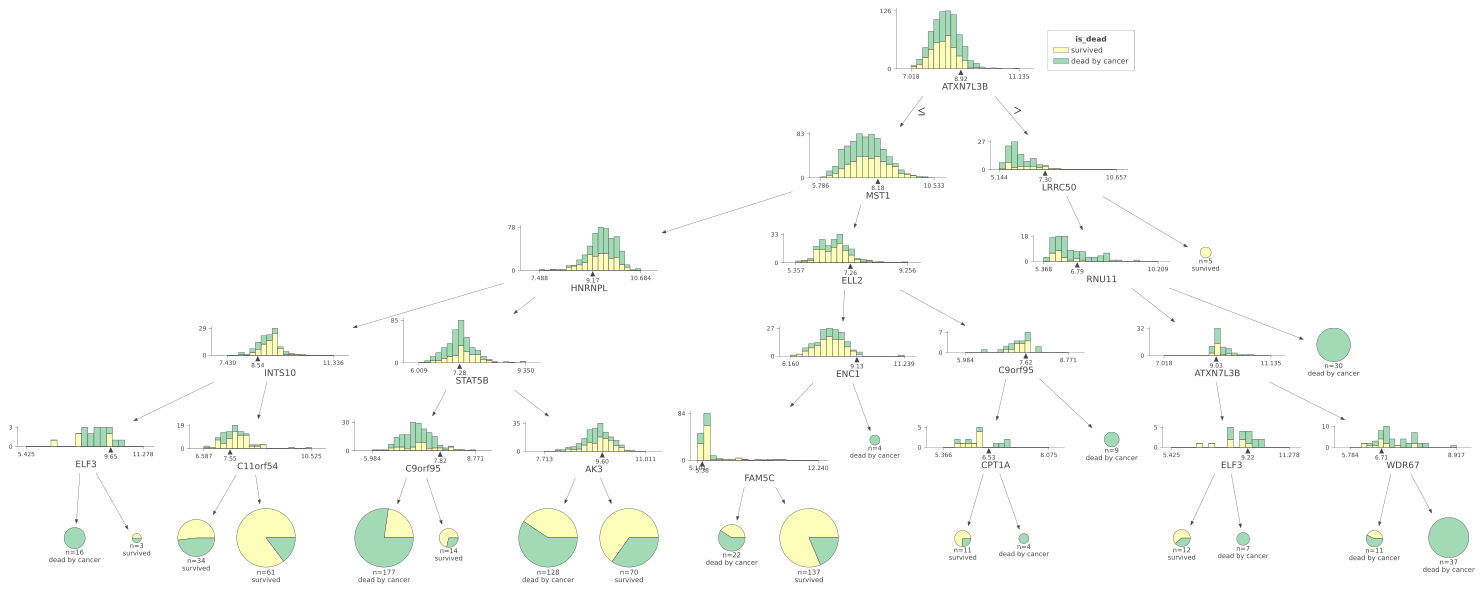

In [5]:
viz = dtreeviz(
    rf.estimators_[0],
    X_train,
    y_train,
    feature_names=X_train.columns,
    target_name="is_dead",
    class_names=["survived", "dead by cancer"],
)
viz

In [6]:
X_train.columns

Index(['RACGAP1', 'SMAD6', 'ELL2', 'RND1', 'C12orf76', 'RNU11', 'ENC1',
       'LOC389033', 'WARS2', 'INTS10', 'LSR', 'STAT5B', 'WDR67', 'LRRC50',
       'CPT1A', 'FAM5C', 'TFPT', 'VPS37A', 'FGD3', 'ELF3', 'ZIC2', 'C11orf54',
       'BX105743', 'HNRNPL', 'AK3', 'PREX1', 'DIRAS3', 'ATXN7L3B', 'IGFALS',
       'C9orf95', 'S100P', 'GSTM2', 'KCTD9', 'MST1', 'HIST1H4C'],
      dtype='object')

In [48]:
X_train[["STAT5B"]],

(        STAT5B
 565   7.324243
 1584  7.281772
 1825  7.906659
 1793  6.382593
 712   7.139243
 ...        ...
 902   6.260429
 168   7.864006
 952   7.340555
 1188  7.496744
 1095  7.748449
 
 [792 rows x 1 columns],)

ValueError: attempt to get argmax of an empty sequence

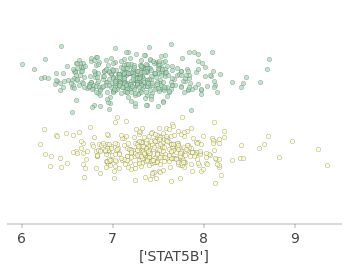

In [51]:
ctreeviz_univar(
    rf.estimators_[0],
    X_train[["STAT5B"]],
    y_train,
    feature_names=["STAT5B"],
    class_names=["survived", "dead by cancer"],
    target_name="is dead",
    nbins=40,
    gtype="strip",
    show={"splits", "title"},
)

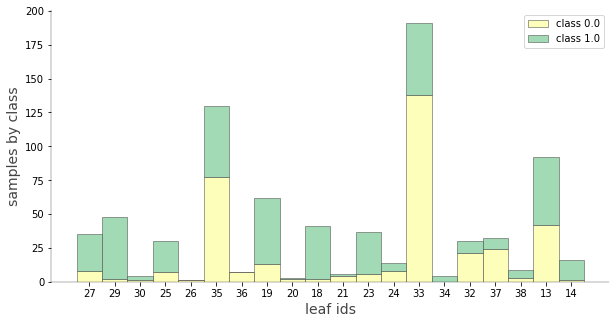

In [53]:
ctreeviz_leaf_samples(rf.estimators_[0], X_train, y_train)

In [57]:
X_train.columns

Index(['NPI', 'PCDH20', 'OSBPL6', 'PTPN20A', 'LEPROTL1', 'WDR67',
       'LYMPH_NODES_EXAMINED_POSITIVE', 'ENC1', 'HIST1H2BF', 'PDCD4', 'FLT3',
       'DB451841', 'INTS10', 'TUMOR_SIZE', 'FAM5C', 'MED10', 'C12orf44',
       'LRRC50', 'STAT5B', 'LOC389033', 'LSR', 'CPT1A', 'VPS37A', 'ELF3',
       'ATXN7L3B', 'GSTM2', 'WARS2', 'PREX1', 'AK3', 'DIRAS3', 'RNU11', 'FGD3',
       'GPRC5A', 'ZIC2', 'MST1'],
      dtype='object')

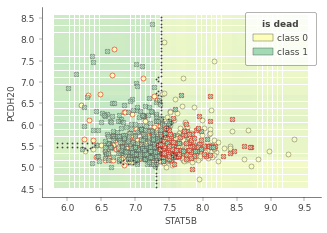

In [76]:
from dtreeviz.classifiers import clfviz

params = {
    "n_estimators": 500,
    "criterion": "entropy",
    "max_depth": 5,
    "max_leaf_nodes": 20,
    "max_features": "log2",
    "class_weight": "balanced",
    "random_state": SEED,
}

features_2d = ["STAT5B", "PCDH20"]
rf2 = RandomForestClassifier(**params)
rf2.fit(X_train[features_2d], y_train)
clfviz(
    rf2,
    X_train[features_2d],
    y_train,
    feature_names=features_2d,
    markers=["o", "X", "s", "D"],
    target_name="is dead",
)

### shap

In [80]:
# load JS visualization code to notebook
shap.initjs()
# Create object that can calculate shap values
explainer = shap.TreeExplainer(rf)
# Calculate SHAP values
shap_values = explainer.shap_values(X_train)

shap.force_plot(explainer.expected_value[0], shap_values[0])

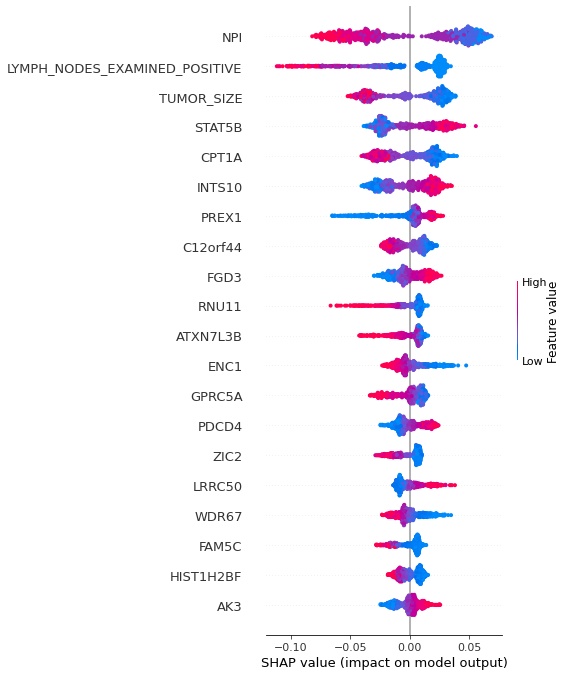

In [90]:
shap.summary_plot(shap_values[0], X_train, show=False)
plt.tight_layout()
plt.savefig("shap_values.jpeg")

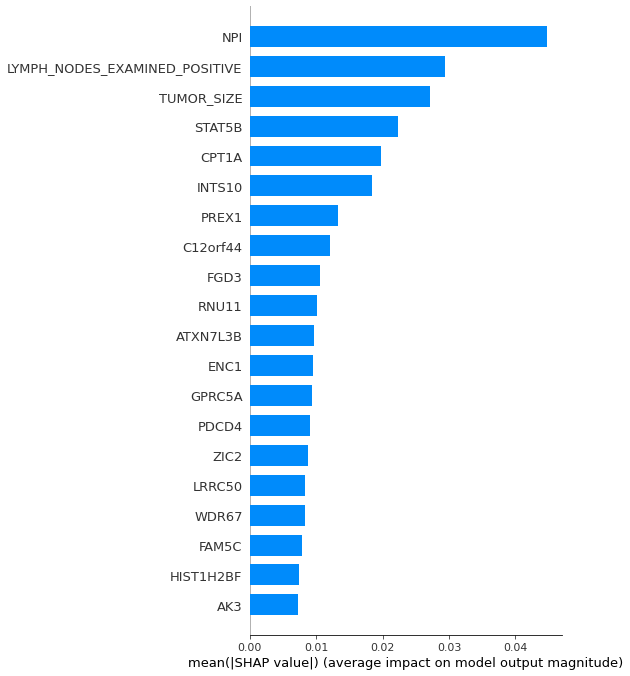

In [89]:
shap.summary_plot(shap_values[0], X_train, plot_type="bar", show=False)
plt.tight_layout()
plt.savefig("importance.jpeg")